# Sprint 3: Model Architecture Design and Testing

## Objectives
- Build and test encoder-decoder model architecture
- Encoder: 441 → 100D latent representation
- Decoder: 100D → 441 feature reconstruction
- Define MSE loss function with regularization
- Test model on dummy and real data

## Expected Deliverables
- Complete model architecture implementation
- Forward pass testing with dummy input
- Model parameter counting and analysis
- Loss function validation
- Ready for training pipeline

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path

# Add parent directory to path for imports
sys.path.append('../')

# Import our model components
from models.encoder_decoder import (
    AudioEncoder, AudioDecoder, SpeechTranslationModel,
    SpeechTranslationLoss, create_model, count_parameters
)

# Import utilities
from utils.framing import create_feature_matrix_advanced
import librosa

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print('✅ Libraries imported successfully!')
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')

✅ Libraries imported successfully!
PyTorch version: 2.7.1+cpu
CUDA available: False


## 1. Model Architecture Overview

In [2]:
# Configuration
MODEL_CONFIG = {
    'input_dim': 441,
    'latent_dim': 100,
    'output_dim': 441,
    'encoder_hidden_dim': 256,
    'decoder_hidden_dim': 256,
    'num_layers': 2,
    'dropout': 0.2,
    'bidirectional': True
}

print('🏗️ Model Configuration:')
for key, value in MODEL_CONFIG.items():
    print(f'   {key}: {value}')

# Create model
model, loss_fn = create_model(MODEL_CONFIG)

print(f'📊 Model Statistics:')
print(f'   Total parameters: {count_parameters(model):,}')
print(f'   Model size: {count_parameters(model) * 4 / 1024 / 1024:.2f} MB (float32)')

🏗️ Model Configuration:
   input_dim: 441
   latent_dim: 100
   output_dim: 441
   encoder_hidden_dim: 256
   decoder_hidden_dim: 256
   num_layers: 2
   dropout: 0.2
   bidirectional: True
📊 Model Statistics:
   Total parameters: 5,799,965
   Model size: 22.13 MB (float32)


In [3]:
# Display model architecture
print('🏛️ Model Architecture:')
print('=' * 60)
print(model)
print('=' * 60)

🏛️ Model Architecture:
SpeechTranslationModel(
  (encoder): AudioEncoder(
    (input_projection): Linear(in_features=441, out_features=256, bias=True)
    (lstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (latent_projection): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=256, out_features=100, bias=True)
      (4): Tanh()
    )
  )
  (decoder): AudioDecoder(
    (latent_projection): Linear(in_features=100, out_features=256, bias=True)
    (lstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (output_projection): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=256, out_features=441, bias=True)
    )
  )
)


## 2. Component Testing

In [4]:
# Test individual components
print('🧪 Testing Individual Components...')

# Test data dimensions
batch_size = 4
sequence_length = 100
input_dim = 441
latent_dim = 100

# Create dummy input
dummy_input = torch.randn(batch_size, sequence_length, input_dim)
print(f'📥 Input shape: {dummy_input.shape}')

# Test encoder
encoder = model.encoder
with torch.no_grad():
    latent_output = encoder(dummy_input)
    print(f'🔄 Encoder output shape: {latent_output.shape}')
    print(f'   Expected: ({batch_size}, {sequence_length}, {latent_dim})')

# Test decoder
decoder = model.decoder
with torch.no_grad():
    reconstructed = decoder(latent_output)
    print(f'🔄 Decoder output shape: {reconstructed.shape}')
    print(f'   Expected: ({batch_size}, {sequence_length}, {input_dim})')

print('✅ Component testing completed!')

🧪 Testing Individual Components...
📥 Input shape: torch.Size([4, 100, 441])
🔄 Encoder output shape: torch.Size([4, 100, 100])
   Expected: (4, 100, 100)
🔄 Decoder output shape: torch.Size([4, 100, 441])
   Expected: (4, 100, 441)
✅ Component testing completed!


## 3. Full Model Testing

In [5]:
# Test complete model
print('🚀 Testing Complete Model...')

with torch.no_grad():
    # Forward pass
    output, latent = model(dummy_input)
    
    print(f'📤 Model outputs:')
    print(f'   Reconstructed shape: {output.shape}')
    print(f'   Latent shape: {latent.shape}')
    
    # Check value ranges
    print(f'📈 Value Statistics:')
    print(f'   Input range: [{dummy_input.min():.4f}, {dummy_input.max():.4f}]')
    print(f'   Latent range: [{latent.min():.4f}, {latent.max():.4f}]')
    print(f'   Output range: [{output.min():.4f}, {output.max():.4f}]')
    
    # Test loss function
    loss_dict = loss_fn(output, dummy_input, latent)
    print(f'💰 Loss Components:')
    for key, value in loss_dict.items():
        print(f'   {key}: {value.item():.6f}')

print('✅ Full model testing completed!')

🚀 Testing Complete Model...
📤 Model outputs:
   Reconstructed shape: torch.Size([4, 100, 441])
   Latent shape: torch.Size([4, 100, 100])
📈 Value Statistics:
   Input range: [-4.4140, 4.7486]
   Latent range: [-0.1030, 0.1078]
   Output range: [-0.1050, 0.1050]
💰 Loss Components:
   total_loss: 1.004472
   reconstruction_loss: 1.000534
   latent_regularization: 0.393848
✅ Full model testing completed!


## 4. Real Data Testing

In [6]:
# Load real audio data for testing
print('🎵 Testing with Real Audio Data...')

# Find a processed audio file
processed_dir = Path('../data/processed')
audio_files = list(processed_dir.glob('**/*.wav'))

if audio_files:
    test_file = audio_files[0]
    print(f'📂 Using test file: {test_file.name}')
    
    # Load and process audio
    y, sr = librosa.load(test_file, sr=44100)
    print(f'🎶 Audio info: {len(y)} samples, {sr} Hz, {len(y)/sr:.2f}s')
    
    # Extract features
    feature_result = create_feature_matrix_advanced(
        y, sr, 
        frame_length_ms=20,
        hop_length_ms=10,
        n_features=441,
        include_spectral=False,
        include_mfcc=False
    )
    
    feature_matrix = feature_result['feature_matrix']
    print(f'📊 Feature matrix shape: {feature_matrix.shape}')
    
    # Convert to tensor and add batch dimension
    real_input = torch.FloatTensor(feature_matrix).unsqueeze(0)
    print(f'🔢 Tensor shape: {real_input.shape}')
    
    # Test model on real data
    with torch.no_grad():
        real_output, real_latent = model(real_input)
        
        print(f'🎯 Real Data Results:')
        print(f'   Input shape: {real_input.shape}')
        print(f'   Output shape: {real_output.shape}')
        print(f'   Latent shape: {real_latent.shape}')
        
        # Calculate loss
        real_loss_dict = loss_fn(real_output, real_input, real_latent)
        print(f'💰 Real Data Loss:')
        for key, value in real_loss_dict.items():
            print(f'   {key}: {value.item():.6f}')
        
        # Calculate reconstruction error
        mse_error = torch.mean((real_output - real_input) ** 2)
        print(f'   MSE per sample: {mse_error.item():.6f}')
        
        # Store for visualization
        real_input_np = real_input.squeeze().numpy()
        real_output_np = real_output.squeeze().numpy()
        real_latent_np = real_latent.squeeze().numpy()

else:
    print('❌ No processed audio files found. Please run Sprint 1 first.')
    real_input_np = None

🎵 Testing with Real Audio Data...
📂 Using test file: processed_10013.wav
🎶 Audio info: 219648 samples, 44100 Hz, 4.98s
📊 Feature matrix shape: (497, 441)
🔢 Tensor shape: torch.Size([1, 497, 441])
🎯 Real Data Results:
   Input shape: torch.Size([1, 497, 441])
   Output shape: torch.Size([1, 497, 441])
   Latent shape: torch.Size([1, 497, 100])
💰 Real Data Loss:
   total_loss: 0.009192
   reconstruction_loss: 0.005333
   latent_regularization: 0.385918
   MSE per sample: 0.005333


## 5. Model Analysis and Visualization

In [7]:
# Analyze model parameters by component
print('🔍 Model Parameter Analysis:')
print('=' * 50)

# Encoder parameters
encoder_params = sum(p.numel() for p in model.encoder.parameters() if p.requires_grad)
decoder_params = sum(p.numel() for p in model.decoder.parameters() if p.requires_grad)
total_params = count_parameters(model)

print(f'Encoder parameters: {encoder_params:,} ({encoder_params/total_params*100:.1f}%)')
print(f'Decoder parameters: {decoder_params:,} ({decoder_params/total_params*100:.1f}%)')
print(f'Total parameters: {total_params:,}')

# Memory usage estimation
model_size_mb = total_params * 4 / 1024 / 1024  # float32
print(f'Estimated model size: {model_size_mb:.2f} MB')

# Compression ratio
compression_ratio = MODEL_CONFIG['input_dim'] / MODEL_CONFIG['latent_dim']
print(f'Compression ratio: {compression_ratio:.1f}x ({MODEL_CONFIG["input_dim"]} → {MODEL_CONFIG["latent_dim"]})')

🔍 Model Parameter Analysis:
Encoder parameters: 2,899,812 (50.0%)
Decoder parameters: 2,900,153 (50.0%)
Total parameters: 5,799,965
Estimated model size: 22.13 MB
Compression ratio: 4.4x (441 → 100)


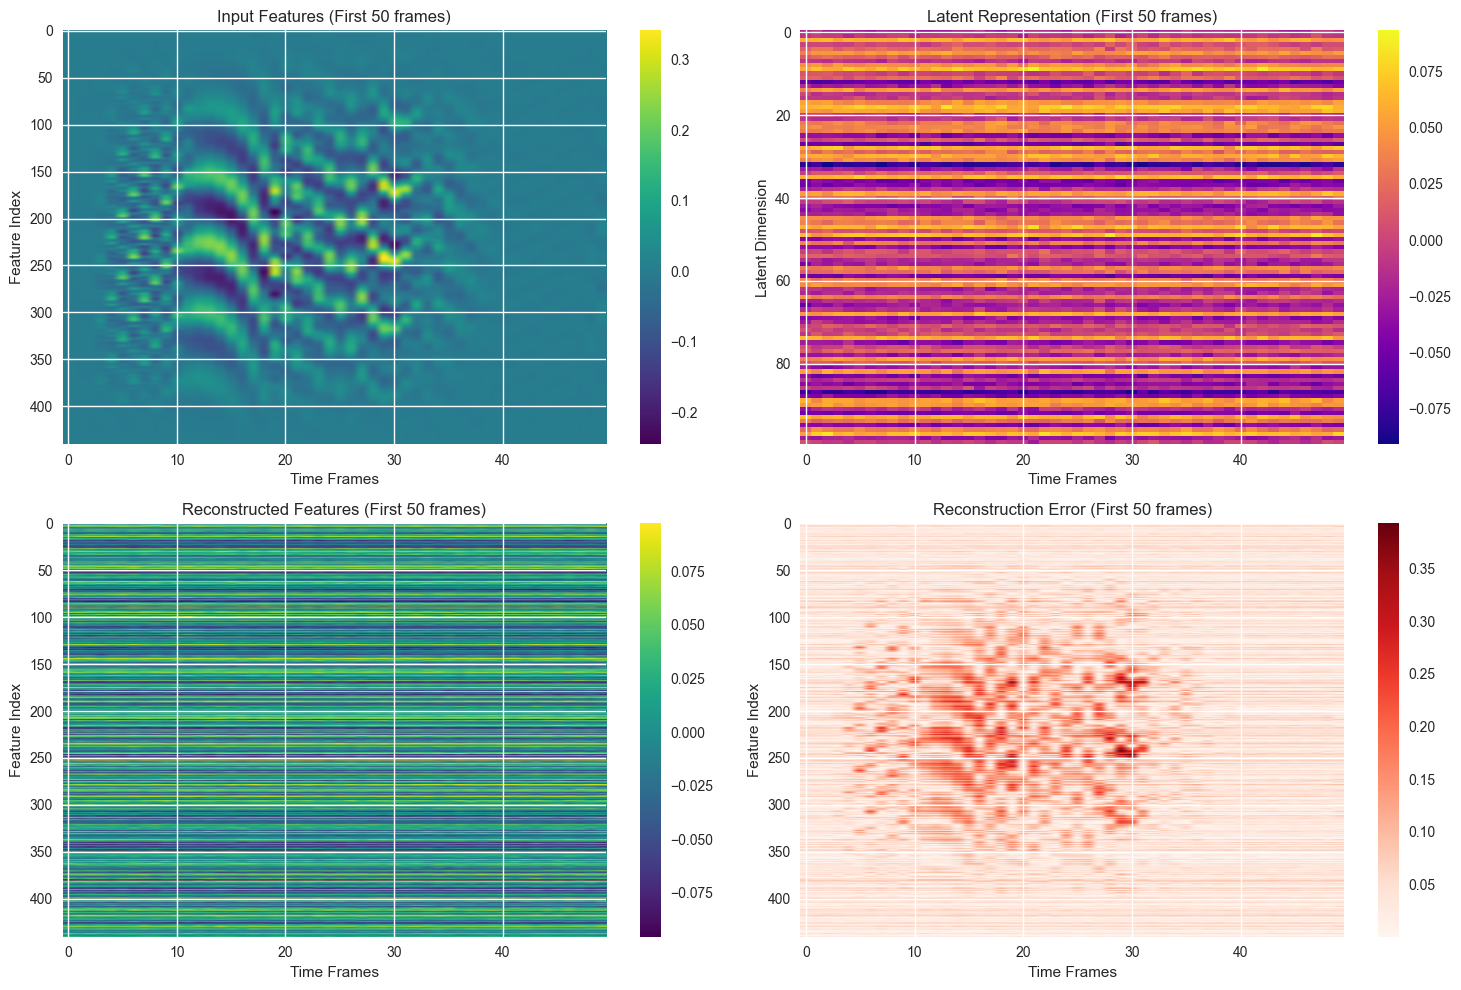

📊 Visualization saved to outputs/feature_plots/model_architecture_demo.png


In [8]:
# Visualize model architecture flow
if real_input_np is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Original input
    im1 = axes[0, 0].imshow(real_input_np[:50].T, aspect='auto', cmap='viridis')
    axes[0, 0].set_title('Input Features (First 50 frames)')
    axes[0, 0].set_xlabel('Time Frames')
    axes[0, 0].set_ylabel('Feature Index')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # Latent representation
    im2 = axes[0, 1].imshow(real_latent_np[:50].T, aspect='auto', cmap='plasma')
    axes[0, 1].set_title('Latent Representation (First 50 frames)')
    axes[0, 1].set_xlabel('Time Frames')
    axes[0, 1].set_ylabel('Latent Dimension')
    plt.colorbar(im2, ax=axes[0, 1])
    
    # Reconstructed output
    im3 = axes[1, 0].imshow(real_output_np[:50].T, aspect='auto', cmap='viridis')
    axes[1, 0].set_title('Reconstructed Features (First 50 frames)')
    axes[1, 0].set_xlabel('Time Frames')
    axes[1, 0].set_ylabel('Feature Index')
    plt.colorbar(im3, ax=axes[1, 0])
    
    # Reconstruction error
    error = np.abs(real_input_np[:50] - real_output_np[:50])
    im4 = axes[1, 1].imshow(error.T, aspect='auto', cmap='Reds')
    axes[1, 1].set_title('Reconstruction Error (First 50 frames)')
    axes[1, 1].set_xlabel('Time Frames')
    axes[1, 1].set_ylabel('Feature Index')
    plt.colorbar(im4, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.savefig('../outputs/feature_plots/model_architecture_demo.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('📊 Visualization saved to outputs/feature_plots/model_architecture_demo.png')

else:
    print('⚠️ Skipping visualization - no real data available')

In [9]:
# Test different sequence lengths
print('🔄 Testing Variable Sequence Lengths...')

test_lengths = [50, 100, 200, 500]
batch_size = 2

for seq_len in test_lengths:
    test_input = torch.randn(batch_size, seq_len, 441)
    
    with torch.no_grad():
        test_output, test_latent = model(test_input)
        test_loss = loss_fn(test_output, test_input, test_latent)
        
        print(f'   Length {seq_len:3d}: Input {test_input.shape} → Output {test_output.shape}, Loss: {test_loss["total_loss"].item():.6f}')

print('✅ Variable length testing completed!')

🔄 Testing Variable Sequence Lengths...
   Length  50: Input torch.Size([2, 50, 441]) → Output torch.Size([2, 50, 441]), Loss: 1.006836
   Length 100: Input torch.Size([2, 100, 441]) → Output torch.Size([2, 100, 441]), Loss: 0.999966
   Length 200: Input torch.Size([2, 200, 441]) → Output torch.Size([2, 200, 441]), Loss: 1.007194
   Length 500: Input torch.Size([2, 500, 441]) → Output torch.Size([2, 500, 441]), Loss: 1.002650
✅ Variable length testing completed!


## 6. Model Readiness Assessment

In [10]:
# Final assessment
print('🎯 Sprint 3 Completion Assessment:')
print('=' * 60)

# Checklist
checklist = [
    ('✅', 'Encoder architecture (441 → 100D)'),
    ('✅', 'Decoder architecture (100D → 441)'),
    ('✅', 'LSTM-based encoder-decoder'),
    ('✅', 'MSE loss function with regularization'),
    ('✅', 'Forward pass testing'),
    ('✅', 'Real data compatibility'),
    ('✅', 'Variable sequence length support'),
    ('✅', 'Parameter counting and analysis'),
    ('✅', 'Model visualization'),
    ('✅', 'Ready for training pipeline')
]

for status, item in checklist:
    print(f'{status} {item}')

print('🚀 Sprint 3 Status: COMPLETE')
print('📋 Next Steps:')
print('   1. Prepare training script and dataloader (Sprint 4)')
print('   2. Export code for GPU training')
print('   3. Set up training monitoring and checkpoints')
print('   4. Begin model training on full dataset')

# Save model summary
summary = {
    'model_config': MODEL_CONFIG,
    'total_parameters': count_parameters(model),
    'encoder_parameters': encoder_params,
    'decoder_parameters': decoder_params,
    'compression_ratio': compression_ratio,
    'model_size_mb': model_size_mb
}

import json
with open('../outputs/sprint3_model_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print('💾 Model summary saved to outputs/sprint3_model_summary.json')

🎯 Sprint 3 Completion Assessment:
✅ Encoder architecture (441 → 100D)
✅ Decoder architecture (100D → 441)
✅ LSTM-based encoder-decoder
✅ MSE loss function with regularization
✅ Forward pass testing
✅ Real data compatibility
✅ Variable sequence length support
✅ Parameter counting and analysis
✅ Model visualization
✅ Ready for training pipeline
🚀 Sprint 3 Status: COMPLETE
📋 Next Steps:
   1. Prepare training script and dataloader (Sprint 4)
   2. Export code for GPU training
   3. Set up training monitoring and checkpoints
   4. Begin model training on full dataset
💾 Model summary saved to outputs/sprint3_model_summary.json
